In [2]:
import pandas as pd
from boruta import BorutaPy
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [3]:
#read data
X=pd.read_csv('.\\alternative_data_set\\X_diesel.csv',header=None)
Y=pd.read_csv('.\\alternative_data_set\\Y3_diesel.csv',header=None)

<Axes: >

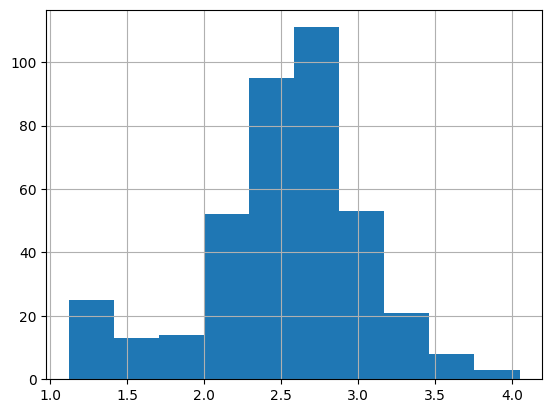

In [19]:
Y.hist()

In [4]:
#remove missing values
X=X.copy()
X['target_variable']=Y[1]
X=X.dropna()
X=X.reset_index(drop=True)
Y=X.iloc[:,401]
X=X.iloc[:,:401]

In [5]:
#data split and normalisation
mean=X.mean()
std=X.std()
X=(X-mean)/std

x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [6]:
x_train.shape

(296, 401)

In [7]:
#fitting model

model_nn = MLPRegressor(hidden_layer_sizes=(2),
                        max_iter=10000,
                        random_state=42,)

#fit
model_nn.fit(x_train,y_train)

#get predictions
test_pred_rf=model_nn.predict(x_test)
train_pred_rf=model_nn.predict(x_train)

test_mse = mean_squared_error(y_test, test_pred_rf)
train_mse=mean_squared_error(y_train,train_pred_rf)

print('train mse: ' +str(train_mse)+'\n'+'test mse: '+str(test_mse))


train mse: 0.12370648886679111
test mse: 0.15073769891816027


Text(0.5, 1.0, "Before 'boruta'")

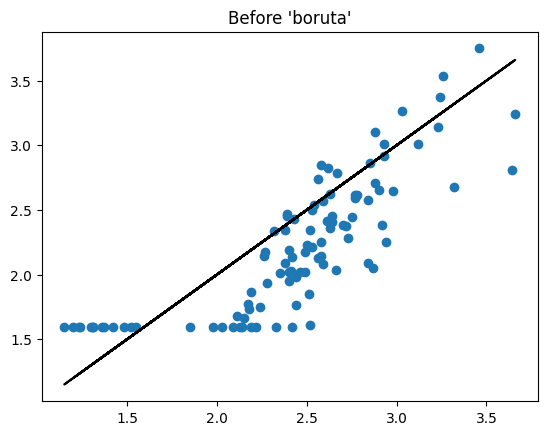

In [8]:
#parity test
plt.scatter(y_test, test_pred_rf)
plt.plot(y_test,y_test,'black')
plt.title('Before \'boruta\'')

In [9]:

# Train your MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(2),
                      max_iter=10000,
                      random_state=42,)

mlp.fit(x_train, y_train)

# Perform permutation importance
results = permutation_importance(mlp, x_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importance of the features
importance = results.importances_mean

# Print the feature importance
for i in range(len(importance)):
    print(f"Feature {i}: Importance: {importance[i]}")

Feature 0: Importance: 0.025273788837300415
Feature 1: Importance: 0.004818029458721129
Feature 2: Importance: -0.01519061306850955
Feature 3: Importance: 0.01851462636805169
Feature 4: Importance: 0.0068460941378539085
Feature 5: Importance: 0.023506115656032465
Feature 6: Importance: -0.0031423140406691696
Feature 7: Importance: -0.015332103426328935
Feature 8: Importance: -0.0013912885182363888
Feature 9: Importance: -0.007599302395672203
Feature 10: Importance: -0.007731594231788352
Feature 11: Importance: -0.007128184329747311
Feature 12: Importance: 0.009330686772488184
Feature 13: Importance: -0.0018648523785986914
Feature 14: Importance: -0.009613301660204753
Feature 15: Importance: -0.008726983088036055
Feature 16: Importance: 0.028198122355513933
Feature 17: Importance: 0.017164656010344947
Feature 18: Importance: -0.014413446168768574
Feature 19: Importance: 0.002174466220406057
Feature 20: Importance: -0.0008029646501384824
Feature 21: Importance: 0.02211537706147878
Featur

In [10]:
#append importance to df
X.loc[len(X)]=importance

#get indexing of only features with importance over 0.2
important_cols=(X.T[X.iloc[395,:]>0.05]).T.columns


In [11]:
x_train_important=x_train[important_cols]
x_test_important=x_test[important_cols]

In [12]:
#get predictions
model_nn=MLPRegressor(hidden_layer_sizes=(2),
                      max_iter=10000,
                      random_state=42,)

model_nn.fit(x_train_important,y_train)


test_pred_important=model_nn.predict(x_test_important)
train_pred_important=model_nn.predict(x_train_important)

test_mse_i = mean_squared_error(y_test, test_pred_important)
train_mse_i=mean_squared_error(y_train,train_pred_important)

print('train mse: ' +str(train_mse_i)+'\n'+'test mse: '+str(test_mse_i))

train mse: 0.08629585940517973
test mse: 0.10366543485069592


Text(0.5, 1.0, "After 'Boruta'")

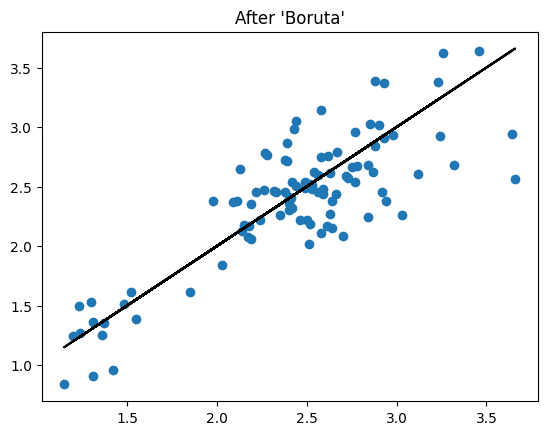

In [13]:
#parity test
plt.scatter(y_test, test_pred_important)
plt.plot(y_test,y_test,'black')
plt.title('After \'Boruta\'')

In [14]:
#get some values for different training
columns = ['importance higher than', 'Test_MSE', 'Train_MSE']
storedstuff = pd.DataFrame(columns=columns)
for i in np.arange(0,0.3,0.05):
    #append importance to df
    X.loc[len(X)]=importance

    #get indexing of only features with importance over 0.2
    important_cols=(X.T[X.iloc[395,:]>i]).T.columns
    
    x_train_important=x_train[important_cols]
    x_test_important=x_test[important_cols]
    
    #get predictions
    model_nn=MLPRegressor(hidden_layer_sizes=(2),
                          max_iter=10000,
                          random_state=42,)

    model_nn.fit(x_train_important,y_train)


    test_pred_important=model_nn.predict(x_test_important)
    train_pred_important=model_nn.predict(x_train_important)

    test_mse_i = mean_squared_error(y_test, test_pred_important)
    train_mse_i=mean_squared_error(y_train,train_pred_important)
    storedstuff.loc[i] = [i, test_mse_i, train_mse_i]
    
    

ValueError: at least one array or dtype is required

In [ ]:
storedstuff

,Index,Test_MSE,Train_MSE
0.00,0.00,0.092826,0.117755
0.01,0.01,0.052545,0.047258
0.02,0.02,0.093776,0.118595
0.03,0.03,0.294599,0.305175
0.04,0.04,0.052131,0.045437
0.05,0.05,0.022218,0.024025
0.06,0.06,0.048658,0.058418
0.07,0.07,0.041797,0.039390
0.08,0.08,0.023391,0.024823
0.09,0.09,0.042978,0.038973


In [ ]:
storedstuff

,importance higher than,Test_MSE,Train_MSE
0.00,0.00,0.092826,0.117755
0.05,0.05,0.022218,0.024025
0.10,0.10,0.046688,0.048419
0.15,0.15,0.047934,0.053939
0.20,0.20,0.138422,0.149154
0.25,0.25,0.220999,0.217056
